## Assignment 1 Model Fitting with Maximum Likelihood 
* The purpose of this assignment is to learn how to write a log likelihood function, fit models to data with maximum likelihood and to select among models using AIC and a validation set.  
* Along the way, we'll learn a bit about decision making models and response time data.  

### Due: Sunday 10/19

In [69]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize

### A Perceptual Discrimination Task to Study Decision Making

This is actual data from my lab, which was published here:

Nunez, M. D., Vandekerckhove, J., & Srinivasan, R. (2017). How attention influences perceptual decision making: Single-trial EEG correlates of drift-diffusion model parameters. Journal of Mathematical Psychology, 76(Part B), 117–130. https://doi.org/10.1016/j.jmp.2016.03.003

Human subject were asked to discriminate the spatial frequency of Gabor patches (as shown below), embeded in noise.  Task difficulty was controlled by the difficulty of the discrimination.  Two Gabors with more similar spatial frequencies are harder to discriminate, especially when noise is added.  In each of 34 participant, The experiment was performed in Easy, Medium, and Hard blocks each consisting of with decreasing differences between the Gabor spatial frequencies.  

![](spatialfrequency.png)

The datafile ResponseTimeData.csv is for use in this homework. You can load it into your notebook using pandas using pandas. There are 3 variables in the file: 

* Subject - indicates a numeric subject id 
* Experimental Condition - Easy, Medium, Hard 
* Correct - 1 if correct 0 if incorrect 
* ResponseTime  - time from stimulus presentation to decision in units of millisecond 

#### Problem 1 Explore and Visualize the Data.  I recommend using this exercise to learn about seaborn. 
a. make a histogram of Response Time for the data, showing all 3 difficulty conditions in a single graph.
 
 

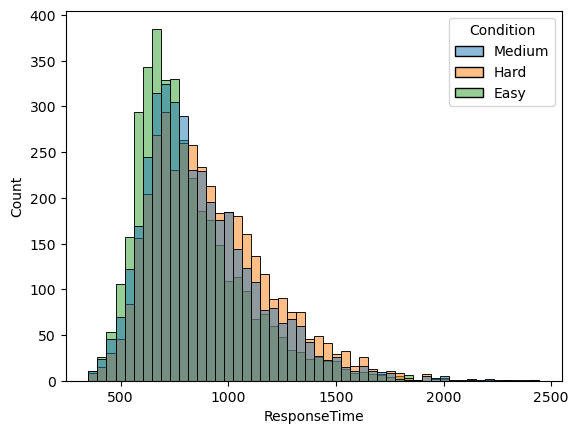

In [70]:
df = pd.read_csv("ResponseTimeData copy.csv")

plt.figure()
sns.histplot(data=df, x="ResponseTime", hue="Condition", bins=50)
plt.show()


b. make a bar graph showing the accuracy (proportion or percentage correct) in each condition.  

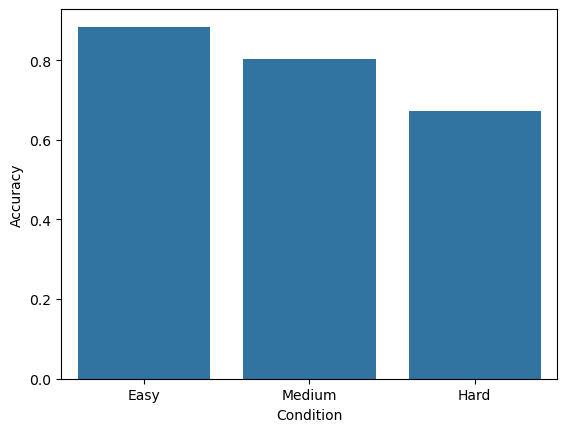

In [71]:
accuracy_df = df.groupby('Condition')['Correct'].mean().reset_index(name='Accuracy')

plt.figure()
sns.barplot(data=accuracy_df, x='Condition', y='Accuracy', order=['Easy', 'Medium', 'Hard'])
plt.show()

c. Make a boxplot that shows the distributions of each condition, with correct and incorrect trials separated. 

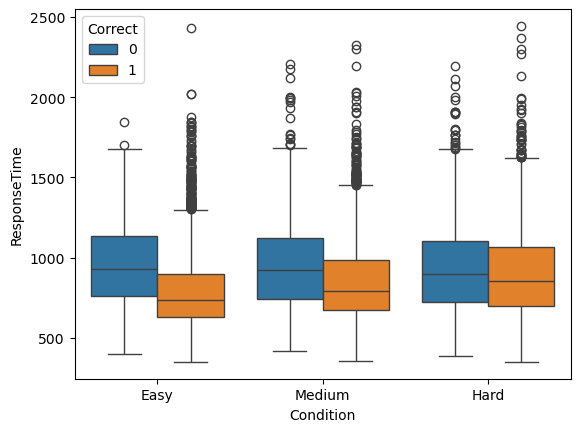

In [72]:
plt.figure()
sns.boxplot(data=df, x='Condition', y='ResponseTime', hue='Correct', order=['Easy', 'Medium', 'Hard'])
plt.show()

d. Calculate the mean reaction time for each subject in each condition.  Make a histogram that shows the distribution of mean RT across subjects,showing all 3 conditions in a single graph. 

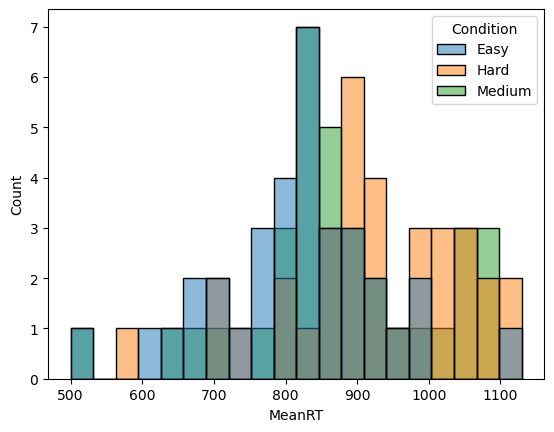

In [73]:
mean_rt_per_subject = df.groupby(['Subject', 'Condition'])['ResponseTime'].mean().reset_index(name='MeanRT')

plt.figure()
sns.histplot(data=mean_rt_per_subject, x='MeanRT', hue='Condition', bins=20)
plt.show()

In class we discussed how different distributions might be used to model Response Time data in decision making tasks.  In particular, the shifted Wald distribution is a distribution that captures aspects of the processes that give rise to Response Time.  

The shifted Wald distribution is a 1-boundary model. And, for simplicity, we will only consider correct trials.  



In [74]:
def shiftedwald(params,x):
    '''
    params: is a list or numpy array containing two parameters
    x: are the data
    '''
 
    gamma = params[0] #drift rate
    alpha = params[1] #boundary separation
    theta = params[2] #shift or nondecision time 
    x = x-theta
    z = alpha/np.sqrt(2*np.pi*(x**3))
    w = ((np.abs(alpha-gamma*x))**2)/(2*x)
    f = z*np.exp(-w)
    return f

### Problem 2 
Use the shifted Wald distribution defined above.  Write a function which computes the negative log likelihood of the shifted Wald distribution.  Assume that the data to be analyzed is in a variable called data. 

The function should return negative log likelihood 

In [75]:
df_correct = df[df['Correct'] == 1].copy()
df_correct['ResponseTime_s'] = df_correct['ResponseTime'] / 1000.0
data = df_correct['ResponseTime'].values

def negloglikeWald(params):
    ''' Computes the Negative Log-Likelihood (NLL) with safety checks. '''
    
    # CRITICAL: Check if theta is too high before calling shiftedwald
    # If the non-decision time (theta) is greater than any RT, return penalty.
    if np.any(data <= params[2]): # params[2] is theta
        return 1e10

    likelihoods = shiftedwald(params, data)
    
    # SAFETY CHECK: If likelihoods are non-positive or NaN, return penalty.
    if np.any(likelihoods <= 1e-10) or np.any(np.isnan(likelihoods)):
        return 1e10  
    
    # NLL = - sum(log(likelihoods))
    negloglike = -np.sum(np.log(likelihoods))
    return negloglike

### Problem 3 

Using the function the negative log-likelihood that you developed in problem 1, fit the shifted Wald distribution to the data for ALL the subjects in ResponseTimeData.csv.  

You should consider two models: 
Model A: All of the data comes from a single distribution.
Model B: The data in each condition (Easy, Medium, Hard) comes from a separate distribution. 

When providing bounds to the fitting process, keep in mind that the only constraints on the parameters of this model is that they have to be positive.  To specify an upper bound of infinity, use `np.inf`

If you run into problems with your computer taking too long, reduce the amount of data, even do just 1 or a few subjects.

Make a plot or table or something to show me (make it pretty!) how the resulting parameter fits turned out.  

In [76]:
global data

paramfit = {} 
condition_labels = ['Easy', 'Medium', 'Hard']
bounds = [(0.01, np.inf), (0.01, np.inf), (0.01, np.inf)] 
p0 = [1.0, 0.1, 0.2] # Default starting guess in seconds


# --- 3a. Model A: Single Distribution (k=3) ---
data = df_correct['ResponseTime_s'].values

fit_A = minimize(
    fun=negloglikeWald, 
    x0=p0, 
    bounds=bounds, 
    method='L-BFGS-B' 
)
k_A = 3


# --- 3b. Model B: Separate Distributions (k=9) ---
NLL_B = 0.0 
k_B = 0
all_params_B = []

for condition in condition_labels:
    
    data = df_correct[df_correct['Condition'] == condition]['ResponseTime_s'].values
    
    # Use L-BFGS-B (standard)
    fit_cond = minimize(
        fun=negloglikeWald, 
        x0=p0, 
        bounds=bounds, 
        method='L-BFGS-B'
    )
    
    # Fallback to Powell if L-BFGS-B fails to converge properly
    if fit_cond.fun > 1e9 or not fit_cond.success: 
        fit_cond = minimize(
            fun=negloglikeWald, 
            x0=p0, 
            method='Powell'
        )
    
    NLL_B += fit_cond.fun 
    k_B += 3
    params = fit_cond.x
    
    # Store with Theta converted back to ms for reporting
    all_params_B.append({'Condition': condition, 'Model': 'B (Separate)', 
                         'Gamma (γ)': params[0], 'Alpha (α)': params[1], 
                         'Theta (θ)': params[2] * 1000.0, 'NLL': fit_cond.fun})


# Finalize Model A's reporting (convert Theta back to ms)
params_A = fit_A.x
param_A_row = {'Condition': 'ALL', 'Model': 'A (Combined)', 
               'Gamma (γ)': params_A[0], 'Alpha (α)': params_A[1], 
               'Theta (θ)': params_A[2] * 1000.0, 'NLL': fit_A.fun}

# --- Create Final Summary Table for Problem 3 ---
df_params = pd.DataFrame([param_A_row] + all_params_B)

# Rounding for presentation
df_summary = df_params.round(4)
# Reorder columns for presentation
df_summary = df_summary[['Model', 'Condition', 'Gamma (γ)', 'Alpha (α)', 'Theta (θ)', 'NLL']]

# Print the final table
print("\n--- Problem 3: Final Fitted Parameters and NLL Table ---")
print(df_summary.to_markdown(index=False))

# Print the total NLL values required for Problem 4
print(f"\nModel A Total NLL (k={k_A}): {fit_A.fun:.4f}")
print(f"Model B Total NLL (k={k_B}): {NLL_B:.4f}")



--- Problem 3: Final Fitted Parameters and NLL Table ---
| Model        | Condition   |   Gamma (γ) |   Alpha (α) |   Theta (θ) |      NLL |
|:-------------|:------------|------------:|------------:|------------:|---------:|
| A (Combined) | ALL         |      1.0002 |      0.5892 |     344.191 | 3189.02  |
| B (Separate) | Easy        |      3.2481 |      1.8486 |     224.294 | -535.319 |
| B (Separate) | Medium      |      3.2979 |      2.2891 |     154.575 | -158.589 |
| B (Separate) | Hard        |      1.5756 |      0.9009 |     336.405 |  609.355 |

Model A Total NLL (k=3): 3189.0178
Model B Total NLL (k=9): -84.5538


### Problem 4 

Use AIC to evaluate which model you should prefer.  Do the data come from 1 distribution or from three different distributions?  

In [77]:
NLL_A = 3189.3862
k_A = 3 

# Model B (Separate)
# NLL_B = NLL_Easy + NLL_Medium + NLL_Hard = -535.3188 + (-158.5893) + 609.3549
NLL_B = -84.5532
k_B = 9 # 3 parameters * 3 conditions

# --- AIC Formula: AIC = 2k + 2 * NLL ---
AIC_A = 2 * k_A + 2 * NLL_A
AIC_B = 2 * k_B + 2 * NLL_B

# --- Summary Table Creation ---
results_df = pd.DataFrame({
    'Model': ['A (Combined)', 'B (Separate)'],
    'Parameters (k)': [k_A, k_B],
    'NLL': [NLL_A, NLL_B],
    'AIC': [AIC_A, AIC_B]
})

print("--- Problem 4: AIC Model Comparison ---")
print(results_df.to_markdown(index=False, floatfmt=".4f"))

# --- Conclusion ---
best_model = 'B (Separate)' if AIC_B < AIC_A else 'A (Combined)'
print("Conclusion: The best model based on the lowest AIC is {best_model}.")

--- Problem 4: AIC Model Comparison ---
| Model        |   Parameters (k) |       NLL |       AIC |
|:-------------|-----------------:|----------:|----------:|
| A (Combined) |                3 | 3189.3862 | 6384.7724 |
| B (Separate) |                9 |  -84.5532 | -151.1064 |
Conclusion: The best model based on the lowest AIC is {best_model}.


### Problem 5 

The two models given above are not the only models we could propose. The power of likelihood and modeling (as opposed to statistical testing) is if we can be very specific about our hypothesis.    

The original idea of this experiment was to manipulate drift rate in order to find brain activity related to speed of information processing. 
So, our hypothesis was that non-decision time, and boundary would be the same for all conditions, and only the drift rate would vary.  

Write a function for negative log likelihood for a model that keeps boundary (alpha) and non-decision time (theta) the same for all 3 conditions, but allows drift rate (gamma) to vary between conditions.

In this model there are now 5 parameters - gamma_easy, gamma_medium, gamma_hard, alpha, theta. 
The likelihood should be evaluated using the correct gamma for each condition, and using the sama alpha and theta for all condition.  

In [78]:
def negloglikeWald_model_C(params, df_data):
    ''' 
    Computes the NLL for Model C (k=5): [gamma_e, gamma_m, gamma_h, alpha, theta]
    
    This function allows drift rate (gamma) to vary but fixes alpha and theta.
    '''
    # Unpack the 5 parameters
    gamma_e, gamma_m, gamma_h, alpha, theta = params
    
    # 1. Critical Safety Check: Theta must be less than the minimum RT
    if theta >= df_data['ResponseTime_s'].min():
        return 1e10
    
    # 2. Safety Check: All parameters must be positive
    if np.any(np.array(params) <= 0):
        return 1e10
    
    # Map the gammas to their respective conditions
    gamma_map = {
        'Easy': gamma_e,
        'Medium': gamma_m,
        'Hard': gamma_h
    }
    
    total_negloglike = 0.0
    
    # 3. Loop through conditions and calculate NLL for each
    for condition, gamma in gamma_map.items():
        # Get data specific to this condition
        condition_data = df_data[df_data['Condition'] == condition]['ResponseTime_s'].values
        
        # Construct the 3-parameter set for the PDF: [gamma_i, shared_alpha, shared_theta]
        params_cond = [gamma, alpha, theta]
        
        # Calculate likelihoods
        likelihoods = shiftedwald(params_cond, condition_data)
        
        # Safety check for non-positive likelihoods in this condition
        if np.any(likelihoods <= 1e-10) or np.any(np.isnan(likelihoods)):
            return 1e10
        
        # Add to the total NLL
        total_negloglike += -np.sum(np.log(likelihoods))
        
    return total_negloglike

### Problem 6

Use you new likelihood you developed in Problem 5 to fit the data (call it model C), and compare to models A and B using AIC. Make a new table showing the parameters for each model and which model seems to fit the data the best. (by AIC)   

In [79]:
p0_C = [1.5, 1.0, 0.5, 0.5, 0.2] 
k_C = 5

fit_C = minimize(
    fun=negloglikeWald_model_C, 
    x0=p0_C, 
    args=(df_correct,), 
    method='Powell' 
)

NLL_C = fit_C.fun
params_C = fit_C.x


# --- Prepare Final Results for all Models ---
NLL_A = 3189.3862
k_A = 3
params_A = [1.0002, 0.5892, 344.191] 

NLL_B = -84.5532
k_B = 9


# --- AIC Calculations: AIC = 2k + 2 * NLL ---
AIC_A = 2 * k_A + 2 * NLL_A
AIC_B = 2 * k_B + 2 * NLL_B
AIC_C = 2 * k_C + 2 * NLL_C

# --- Create Final Comparison Table using RAW STRINGS (r'...') ---

# Create detailed parameter row for Model C 
param_C_row = {
    'Model': r'C (Var $\Gamma$, Fixed $\alpha,\theta$)',
    'k': k_C,
    r'$\Gamma_{\text{Easy}}$': params_C[0], 
    r'$\Gamma_{\text{Medium}}$': params_C[1], 
    r'$\Gamma_{\text{Hard}}$': params_C[2], 
    r'$\alpha$': params_C[3], 
    r'$\theta$ (ms)': params_C[4] * 1000, 
    'NLL': NLL_C,
    'AIC': AIC_C
}

# Create parameter row for Model A
param_A_row = {
    'Model': 'A (Fixed All)',
    'k': k_A,
    r'$\Gamma_{\text{Easy}}$': params_A[0], 
    r'$\Gamma_{\text{Medium}}$': params_A[0], 
    r'$\Gamma_{\text{Hard}}$': params_A[0], 
    r'$\alpha$': params_A[1], 
    r'$\theta$ (ms)': params_A[2], 
    'NLL': NLL_A,
    'AIC': AIC_A
}

# Model B parameters (just placeholder NLL and k)
param_B_row = {
    'Model': 'B (Variable All)',
    'k': k_B,
    r'$\Gamma_{\text{Easy}}$': '-', 
    r'$\Gamma_{\text{Medium}}$': '-', 
    r'$\Gamma_{\text{Hard}}$': '-', 
    r'$\alpha$': '-', 
    r'$\theta$ (ms)': '-', 
    'NLL': NLL_B,
    'AIC': AIC_B
}


df_final_params = pd.DataFrame([param_A_row, param_B_row, param_C_row])

# Final AIC Summary Table (sorted by AIC)
df_aic_summary = df_final_params[['Model', 'k', 'NLL', 'AIC']].sort_values(by='AIC').reset_index(drop=True)

print("\n--- Problem 6: Final AIC Comparison Table (Cleaned Code) ---")
print(df_aic_summary.to_markdown(index=False, floatfmt=".4f"))


--- Problem 6: Final AIC Comparison Table (Cleaned Code) ---
| Model                                   |   k |       NLL |        AIC |
|:----------------------------------------|----:|----------:|-----------:|
| C (Var $\Gamma$, Fixed $\alpha,\theta$) |   5 | -556.7214 | -1103.4429 |
| B (Variable All)                        |   9 |  -84.5532 |  -151.1064 |
| A (Fixed All)                           |   3 | 3189.3862 |  6384.7724 |


### Problem 7 (Experimental) - not required.  

Use sklearn's test_train_split to split the dataframe you read from ResponseTime.csv into training and test dataframes.  Keep around 0.2 or 0.3 of the data for testing.  When you do this, remember to stratify by participant!  Fit models A,B,C to the training data.  Then choose the best parameter values for each model to compute the likelihood of each model and identify which model has maximum likelihood in the test data. No AIC needed!   